In [1]:
# First, we'll import pandas and numpy, two data processing libraries
import pandas as pd
import numpy as np

# We'll also import seaborn and matplot, twp Python graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt
# Import the needed sklearn libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# The Keras library provides support for neural networks and deep learning
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
#from tensorflow.keras.utils import np_utils
from tensorflow.keras import utils

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print ("Libraries Imported")

Libraries Imported


In [ ]:
# Data from https://www.kaggle.com/datasets/smaranjitghose/sea-turtle-face-detection
# Code from https://www.kaggle.com/code/tgibbons/sea-turtle-face-detection

In [2]:
# define path to the read-only input folder
dataPath = "data/"

# define path to the writable working folder
working_dir = "working/"

# read text file into pandas DataFrame
df_labels = pd.read_csv("data/labels.csv", header=None)
df_labels.columns = ['species', 'upper_left_x', 'upper_left_y', 'bbwidth', 'bblength', 'filename', 'image_width', 'image_length' ]
# display DataFrame
df_labels.head()

,species,upper_left_x,upper_left_y,bbwidth,bblength,filename,image_width,image_length
0,Turtle,639,241,347,259,Image_1.jpg,1000,1000
1,Turtle,632,183,481,441,Image_2.jpg,2000,1000
2,Turtle,378,429,156,119,Image_3.jpg,1200,800
3,Turtle,1368,431,519,377,Image_4.jpg,2500,1667
4,Turtle,1044,1498,1088,772,Image_5.jpg,4613,2968


In [3]:
print("Shape before dropping duplicates " + str(df_labels.shape))
df_labels = df_labels.drop_duplicates(subset='filename', keep=False)
print("Shape after dropping duplicates " + str(df_labels.shape))

Shape before dropping duplicates (2103, 8)
Shape after dropping duplicates (1934, 8)


In [4]:
# This code uses all the images available
df_labels = df_labels[0:]

# This code limits the images to the first 500 and will run faster for training if you need to
df_labels = df_labels[0:500]

df_labels

,species,upper_left_x,upper_left_y,bbwidth,bblength,filename,image_width,image_length
0,Turtle,639,241,347,259,Image_1.jpg,1000,1000
1,Turtle,632,183,481,441,Image_2.jpg,2000,1000
2,Turtle,378,429,156,119,Image_3.jpg,1200,800
3,Turtle,1368,431,519,377,Image_4.jpg,2500,1667
4,Turtle,1044,1498,1088,772,Image_5.jpg,4613,2968
...,...,...,...,...,...,...,...,...
532,Turtle,310,310,148,129,Image_510.jpg,966,642
533,Turtle,731,345,177,143,Image_511.jpg,1600,1000
534,Turtle,407,323,135,129,Image_512.jpg,800,600
535,Turtle,684,312,514,478,Image_513.jpg,1920,1080


In [5]:
IMAGE_SIZE = (224, 224)

In [6]:
# Get YOLO bounding boxes from text files
#df_yolo = pd.DataFrame.empty
labelName = dataPath + "labels/" + df_labels["filename"][0][:-3] + 'txt'
df_yolo = pd.read_csv(labelName, delim_whitespace=True, header=None)
df_yolo.columns = ['idd', 'yolo_x', 'yolo_y','yolo_width', 'yolo_length'] 

# Loop over all the file names, skipping the first one that is done above
for imageName in df_labels["filename"][1:]:
    if (imageName[-4] == '.'):
        # some images have ".jpeg" instead of ".jpg"
        labelName = dataPath + "labels/" + imageName[:-3] + 'txt'
    else:
        labelName = dataPath + "labels/" + imageName[:-4] + 'txt'
    #print (labelName)
    bb_txt = pd.read_csv(labelName, delim_whitespace=True, header=None)
    bb_txt.columns = ['idd', 'yolo_x', 'yolo_y','yolo_width', 'yolo_length'] 
    df_yolo = pd.concat([df_yolo, bb_txt.iloc[[0]] ], ignore_index=True)

    #print (df_yolo)
    
df_yolo.head(10)

,idd,yolo_x,yolo_y,yolo_width,yolo_length
0,0,0.812745,0.370588,0.347059,0.258824
1,0,0.436321,0.403302,0.240566,0.441038
2,0,0.379717,0.610554,0.129717,0.148585
3,0,0.650943,0.371783,0.207547,0.226370
4,0,0.344340,0.634713,0.235849,0.260263
5,0,0.373231,0.468160,0.201651,0.214033
6,0,0.651457,0.394180,0.153787,0.118166
7,0,0.410967,0.408537,0.229953,0.294811
8,0,0.570165,0.413413,0.260613,0.353490
9,0,0.653302,0.455983,0.155660,0.321951


In [7]:
df_labels.reset_index(drop=True, inplace=True)
df_yolo.reset_index(drop=True, inplace=True)

df_all = pd.concat([df_labels, df_yolo], axis=1)
print ("df_labels shape = "+ str(df_labels.shape))
print ("df_yolo shape = "+ str(df_yolo.shape))
print ("df_all shape = "+ str(df_all.shape))

df_labels shape = (500, 8)
df_yolo shape = (500, 5)
df_all shape = (500, 13)


In [8]:
# !pip install scikit-image --user

In [12]:
# Resizing the images into a new folder images224
import os
import skimage.io
import skimage
import cv2
from tqdm import tqdm    # needed for progress bar
import PIL

load_dir = "data/images/"
save_dir = "working/images224/"

print ('Creating a new folder at ' + save_dir)
os.makedirs(save_dir, exist_ok=True)

print ('Looping through all the images in the data frame')

#for imageName in df_labels["filename"][1:]:

for imageName in tqdm(df_labels["filename"]):
    load_path = load_dir + imageName
    save_path = save_dir + imageName
    img = cv2.imread(load_path)
    img_resize = cv2.resize(img, (224, 224))
    plt.imsave(save_path, img_resize)

print ("All images resized and saved to /working/images224/ folder")

  0%|▎                                                                       | 2/500 [00:00<00:25, 19.50it/s]

Creating a new folder at working/images224/
Looping through all the images in the data frame


100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 14.95it/s]

All images resized and saved to /working/images224/ folder


In [13]:
width = 224
length = 224
df_all['resize_upper_x'] = df_all.apply(lambda row: round(row['yolo_x'] * width - 0.5 * row['yolo_width'] * width), axis = 1)
df_all['resize_left_y'] = df_all.apply(lambda row:  round(row['yolo_y'] * length - 0.5 * row['yolo_length'] * length), axis = 1)
df_all['resize_lower_x'] = df_all.apply(lambda row: round(row['yolo_x'] * width + 0.5 * row['yolo_width'] * width), axis = 1)
df_all['resize_right_y'] = df_all.apply(lambda row: round(row['yolo_y'] * length + 0.5 * row['yolo_length'] * length), axis = 1)

In [14]:
df_all

,species,upper_left_x,upper_left_y,bbwidth,bblength,filename,image_width,image_length,idd,yolo_x,yolo_y,yolo_width,yolo_length,resize_upper_x,resize_left_y,resize_lower_x,resize_right_y
0,Turtle,639,241,347,259,Image_1.jpg,1000,1000,0,0.812745,0.370588,0.347059,0.258824,143,54,221,112
1,Turtle,632,183,481,441,Image_2.jpg,2000,1000,0,0.436321,0.403302,0.240566,0.441038,71,41,125,140
2,Turtle,378,429,156,119,Image_3.jpg,1200,800,0,0.379717,0.610554,0.129717,0.148585,71,120,100,153
3,Turtle,1368,431,519,377,Image_4.jpg,2500,1667,0,0.650943,0.371783,0.207547,0.226370,123,58,169,109
4,Turtle,1044,1498,1088,772,Image_5.jpg,4613,2968,0,0.344340,0.634713,0.235849,0.260263,51,113,104,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Turtle,310,310,148,129,Image_510.jpg,966,642,0,0.397557,0.583815,0.153664,0.200385,72,108,106,153
496,Turtle,731,345,177,143,Image_511.jpg,1600,1000,0,0.512042,0.416185,0.110790,0.142582,102,77,127,109
497,Turtle,407,323,135,129,Image_512.jpg,800,600,0,0.593208,0.645472,0.169075,0.215800,114,120,152,169
498,Turtle,684,312,514,478,Image_513.jpg,1920,1080,0,0.489976,0.510482,0.267689,0.442348,80,65,140,164


In [15]:
# https://colab.research.google.com/github/d2l-ai/d2l-en-colab/blob/master/chapter_computer-vision/bounding-box.ipynb#scrollTo=wASmLzN_HAlN

def box_corner_to_center_arr(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = np.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner_arr(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = np.stack((x1, y1, x2, y2), axis=-1)
    return boxes

def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)


def box_center_to_corner(box, width, length):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = box[0], box[1], box[2], box[3]
    x1 = round(cx * width - 0.5 * w * width)
    y1 = round(cy * length - 0.5 * h * length)
    x2 = round(cx * width + 0.5 * w * width)
    y2 = round(cy * length + 0.5 * h * length)
    bbox = [x1, y1, x2, y2]
    return bbox

In [16]:
# Extract bounding boxes from the labels.
#trainBboxes = df_labels.iloc[:,1:6]
#trainBboxes.columns = ['upper_left_x', 'upper_left_y', 'width', 'length', 'filename' ]
#trainBboxes.columns = ['yolo_x', 'yolo_y', 'yolo_width', 'yolo_length', 'filename' ]
#trainBboxes.columns = ['resize_upper_x', 'resize_left_y', 'resize_lower_x', 'resize_right_y', 'filename' ]


#print (trainBboxes)

In [19]:
from glob import glob
from PIL import Image

def plot_images(imgs, rows=5):
    # Set figure to 15 inches x 8 inches
    figure = plt.figure(figsize=(15, 8))
    cols = len(imgs) // rows + 1
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        plt.imshow(imgs[i])

def plot_images_for_filenames(filenames, rows=5):
    imgs = [plt.imread(f'{filename}') for filename in filenames]
    return plot_images(imgs, rows)

def displayTurtle(turtleNum):
    dataPath = "data/"
    image_path = dataPath + "images/Image_" + str(turtleNum) + ".jpg"
    lable_path = dataPath + "labels/Image_" + str(turtleNum) + ".txt"
    # display the image
    img = mpimg.imread(image_path)
    height, width, depth = img.shape
    plt.figure(figsize = (15,15))
    fig = plt.imshow(img)
    # read the yolo cordinates.  read_csv stores the numbers in the column names
    label = pd.read_csv(lable_path, sep=" ")
    yolobbox = list(label.columns[1:5])
    yolobbox = [float(i) for i in yolobbox]    # convert numbers from strings to floats
    print (yolobbox)
    # convert to corners
    bbox = box_center_to_corner(yolobbox, width, height)
    print (bbox)
    fig.axes.add_patch(bbox_to_rect(bbox, 'blue'))

def displayTurtle_resized(turtleNum):
    dataPath = "data/"
    image_path = 'working/images224/' + "Image_" + str(turtleNum) + ".jpg"
    lable_path = dataPath + "labels/Image_" + str(turtleNum) + ".txt"
    # display the image
    img = mpimg.imread(image_path)
    height, width, depth = img.shape
    plt.figure(figsize = (5,5))
    fig = plt.imshow(img)
    # read the yolo cordinates.  read_csv stores the numbers in the column names
    label = pd.read_csv(lable_path, sep=" ")
    yolobbox = list(label.columns[1:5])
    yolobbox = [float(i) for i in yolobbox]    # convert numbers from strings to floats
    print (yolobbox)
    # convert to corners
    bbox = box_center_to_corner(yolobbox, width, height)
    print (bbox)
    fig.axes.add_patch(bbox_to_rect(bbox, 'blue'))

Original Sized Images
['data/images\\Image_101.jpg', 'data/images\\Image_1010.jpg', 'data/images\\Image_1011.jpg', 'data/images\\Image_1012.jpg', 'data/images\\Image_1013.jpg', 'data/images\\Image_1014.jpg', 'data/images\\Image_1015.jpg', 'data/images\\Image_1016.jpg', 'data/images\\Image_1017.jpg', 'data/images\\Image_1018.jpg', 'data/images\\Image_1019.jpg']


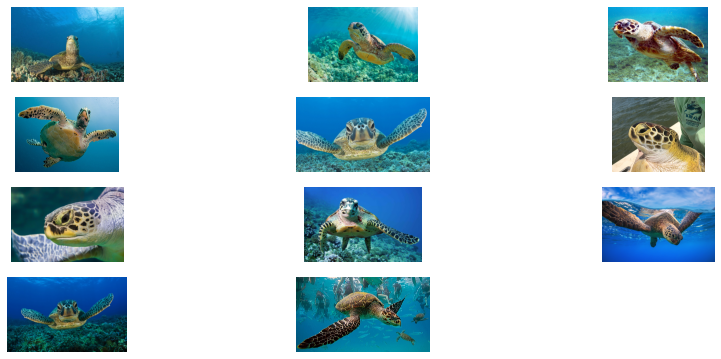

In [21]:
sample_images = glob("data/images/Image_101*.jpg")

print ("Original Sized Images")
print (sample_images)
plot_images_for_filenames(sample_images) 

Resized Images
['working/images224\\Image_101.jpg']


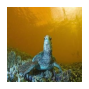

In [23]:
sample_images = glob("working/images224/Image_101*.jpg")

print ("Resized Images")
print (sample_images)
plot_images_for_filenames(sample_images)

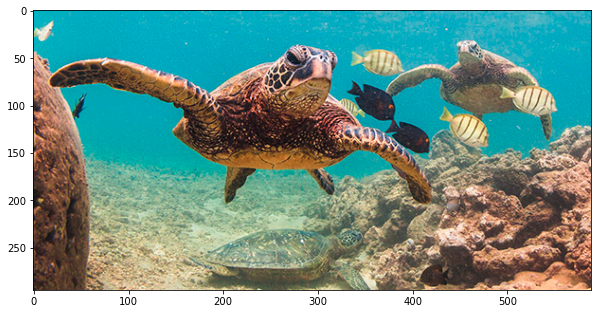

In [24]:
#This is an example of a image with two turtle faces
# from https://www.kaggle.com/code/foucardm/draw-bounding-boxes-for-object-detection
one_image_path = "data/images/Image_18.png"
image = mpimg.imread(one_image_path)
plt.figure(figsize = (10,10))
imgplot = plt.imshow(image)
plt.show()

[0.504127, 0.453774, 0.1875, 0.328302]
[657, 290, 957, 618]


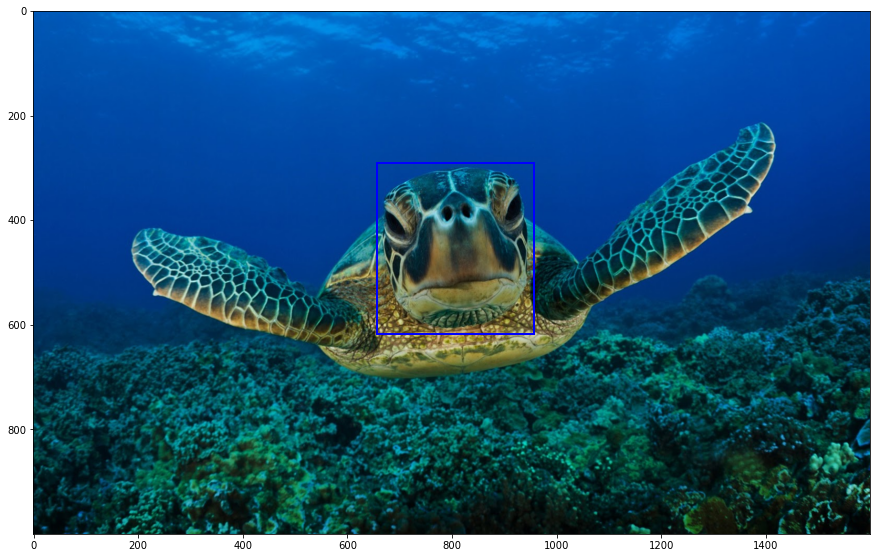

In [25]:
displayTurtle(34)

# Convolutional Neural Network Training

In [26]:
# from https://stackoverflow.com/questions/41749398/using-keras-imagedatagenerator-in-a-regression-model

IMAGE_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    horizontal_flip = True
) 

# This version uses the resized images
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_all, 
    directory=save_dir,                                               
    x_col="filename", 
    #y_col=['resize_upper_x', 'resize_left_y', 'resize_lower_x', 'resize_right_y'], 
    y_col=['yolo_x', 'yolo_y', 'yolo_width', 'yolo_length'], 
    #has_ext=True, 
    class_mode="raw", 
    target_size=IMAGE_SIZE,
    batch_size=32
)

Found 500 validated image filenames.


In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=5, 
                                            verbose=2, 
                                            factor=0.5,                                            
                                            min_lr=0.000001)

early_stops = EarlyStopping(monitor='loss', 
                            min_delta=0, 
                            patience=10, 
                            verbose=2, 
                            mode='auto')

checkpointer = ModelCheckpoint(filepath = 'cis3115.{epoch:02d}-{accuracy:.6f}.hdf5',
                               verbose=2,
                               save_best_only=True, 
                               save_weights_only = True)

In [28]:
# Set up the Neural Network
IMAGE_SIZE = (224, 224)
# ==== Select one of the pre-trained models from Keras.  Samples are shown below
#pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])

# Set the following to False so that the pre-trained weights are not changed 
pretrained_model.trainable = False 

model = Sequential()
#  Start with the pretrained model defined above
model.add(pretrained_model)

# Flatten 2D images into 1D data for final layers like traditional neural network
model.add(Flatten())
# GlobalAveragePooling2D is an alternative to Flatter and reduces the size of the layer while flattening
#model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# The final output layer
# Use Sigmoid when predicting YOLO bounding box since that output is between 0 and 1
#model.add(Dense(4, activation='sigmoid'))
# Use relu when predicting corner pixels since the outputs are intergers larger than 1
#model.add(Dense(4, activation='relu'))
model.add(Dense(4, activation='linear'))


print ("Pretrained model used:")
pretrained_model.summary()

print ("Final model created:")
model.summary()

# Compile neural network model
#model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer='adam', loss='mean_absolute_error')

58900480/58889256 [==============================] - 35s 1us/step
Pretrained model used:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________

In [29]:
# Train the model with the images in the folders
history = model.fit(
        train_generator,
        # validation_data=(testImages, testTargets),
        batch_size=16,                  # Number of image batches to process per epoch 
        epochs=100,                      # Number of epochs
        callbacks=[learning_rate_reduction, early_stops],
    )

Epoch 1/100
16/16 [==============================] - 166s 10s/step - loss: 0.5867
Epoch 2/100
16/16 [==============================] - 159s 10s/step - loss: 0.2373
Epoch 3/100
16/16 [==============================] - 151s 9s/step - loss: 0.1916
Epoch 4/100
16/16 [==============================] - 147s 9s/step - loss: 0.1759
Epoch 5/100
16/16 [==============================] - 157s 10s/step - loss: 0.1549
Epoch 6/100
16/16 [==============================] - 155s 10s/step - loss: 0.1445
Epoch 7/100
16/16 [==============================] - 160s 10s/step - loss: 0.1309
Epoch 8/100
16/16 [==============================] - 151s 9s/step - loss: 0.1028
Epoch 9/100
16/16 [==============================] - 159s 10s/step - loss: 0.1175
Epoch 10/100
16/16 [==============================] - 178s 11s/step - loss: 0.0886
Epoch 11/100
16/16 [==============================] - 158s 10s/step - loss: 0.0815
Epoch 12/100
16/16 [==============================] - 162s 10s/step - loss: 0.0809
Epoch 13/100
16/

In [30]:
# We will display the loss and the accuracy of the model for each epoch
# NOTE: this is a little fancier display than is shown in the textbook
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

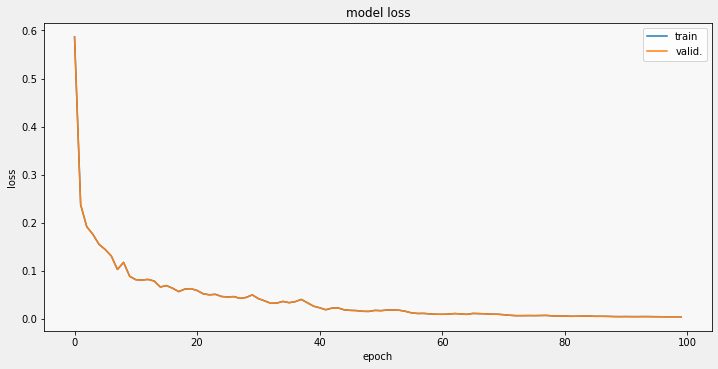

In [31]:
display_training_curves(history.history['loss'], history.history['loss'], 'loss', 211)

In [35]:
# Predict the bounding box
# Original box is in Blue
# Predicted box is in Yellow

def predict_resized_pixels(rowNum):
    row = df_all.iloc[[rowNum]]
    filename = row['filename']
    filename = filename.iloc[0]
    image_path = 'working/images224/' + str(filename)
    # display the image
    img = mpimg.imread(image_path)
    img = img/255     # rescale the image values
    #height, width, depth = img.shape
    plt.figure(figsize = (5,5))
    fig = plt.imshow(img)
    
    # Display to original bounding box
    orig_bbox = row[['resize_upper_x', 'resize_left_y', 'resize_lower_x', 'resize_right_y']]
    orig_bbox = orig_bbox.values.tolist()
    orig_bbox = orig_bbox[0]
    print ('Actual Bounding Box')
    print (orig_bbox)
    fig.axes.add_patch(bbox_to_rect(orig_bbox, 'blue'))
    
    # Predict and display the predicted bounding box
    img2 = cv2.imread(image_path)
    #img = cv2.resize(img,(320,240))
    img = np.reshape(img,[1,224,224,3])

    pred_bbox = model.predict(img)
    pred_bbox = pred_bbox[0]
    print ('Predicted Bounding Box')
    print (pred_bbox)
    fig.axes.add_patch(bbox_to_rect(pred_bbox, 'yellow'))

In [36]:
# Predict the bounding box
# Original box is in Blue
# Predicted box is in Yellow

def predict_yolo(rowNum):
    row = df_all.iloc[[rowNum]]
    filename = row['filename']
    filename = filename.iloc[0]
    image_path = 'working/images224/' + str(filename)
    # display the image
    img = mpimg.imread(image_path)
    height, width, depth = img.shape
    print ('Read in image of size '+str(height) + ' by ' + str(width) + ' by '+ str(depth))
    img = img/255     # rescale the image values
    plt.figure(figsize = (5,5))
    fig = plt.imshow(img)
    
    # Display to original bounding box
    yolo_orig_bbox = row[['yolo_x', 'yolo_y', 'yolo_width', 'yolo_length']]
    yolo_orig_bbox = yolo_orig_bbox.values.tolist()
    yolo_orig_bbox = yolo_orig_bbox[0]
    print ('Actual YOLO Bounding Box')
    print (yolo_orig_bbox)
    orig_bbox = box_center_to_corner(yolo_orig_bbox, 224, 224)
    print ('Actual Pixel Corners Bounding Box')
    print (orig_bbox)
    fig.axes.add_patch(bbox_to_rect(orig_bbox, 'blue'))
    
    # Predict and display the predicted bounding box
    img = np.reshape(img,[1,224,224,3])
    yolo_pred_bbox = model.predict(img)
    yolo_pred_bbox = yolo_pred_bbox[0]
    print ('Predicted YOLO Bounding Box')
    print (yolo_pred_bbox)
    pred_bbox = box_center_to_corner(yolo_pred_bbox, 224, 224)
    print ('Predicted Pixel Corners Bounding Box')
    print (pred_bbox)
    fig.axes.add_patch(bbox_to_rect(pred_bbox, 'yellow'))

Read in image of size 224 by 224 by 3
Actual YOLO Bounding Box
[0.373231, 0.46816, 0.201651, 0.214033]
Actual Pixel Corners Bounding Box
[61, 81, 106, 129]
Predicted YOLO Bounding Box
[0.36951095 0.4673047  0.19790909 0.22147885]
Predicted Pixel Corners Bounding Box
[61, 80, 105, 129]


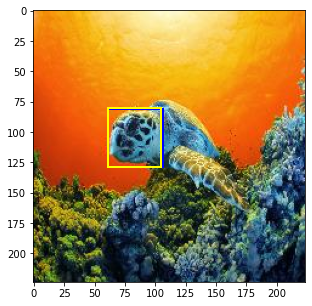

In [39]:
# predict_resized(5)
predict_yolo(5)

In [45]:
def predict_yolo_path(image_path):
    # row = df_all.iloc[[rowNum]]
    # filename = row['filename']
    # filename = filename.iloc[0]
    # image_path = 'working/images224/' + str(filename)
    # display the image
    img = mpimg.imread(image_path)
    img = cv2.resize(img, (224, 224))
    height, width, depth = img.shape
    print ('Read in image of size '+str(height) + ' by ' + str(width) + ' by '+ str(depth))
    img = img/255     # rescale the image values
    plt.figure(figsize = (5,5))
    fig = plt.imshow(img)
    
    # Display to original bounding box
    # yolo_orig_bbox = row[['yolo_x', 'yolo_y', 'yolo_width', 'yolo_length']]
    # yolo_orig_bbox = yolo_orig_bbox.values.tolist()
    # yolo_orig_bbox = yolo_orig_bbox[0]
    # print ('Actual YOLO Bounding Box')
    # print (yolo_orig_bbox)
    # orig_bbox = box_center_to_corner(yolo_orig_bbox, 224, 224)
    # print ('Actual Pixel Corners Bounding Box')
    # print (orig_bbox)
    # fig.axes.add_patch(bbox_to_rect(orig_bbox, 'blue'))
    
    # Predict and display the predicted bounding box
    img = np.reshape(img,[1,224,224,3])
    yolo_pred_bbox = model.predict(img)
    yolo_pred_bbox = yolo_pred_bbox[0]
    print ('Predicted YOLO Bounding Box')
    print (yolo_pred_bbox)
    pred_bbox = box_center_to_corner(yolo_pred_bbox, 224, 224)
    print ('Predicted Pixel Corners Bounding Box')
    print (pred_bbox)
    fig.axes.add_patch(bbox_to_rect(pred_bbox, 'yellow'))

Read in image of size 224 by 224 by 3
Predicted YOLO Bounding Box
[0.49067953 0.49083307 0.5683046  0.8483281 ]
Predicted Pixel Corners Bounding Box
[46, 15, 174, 205]


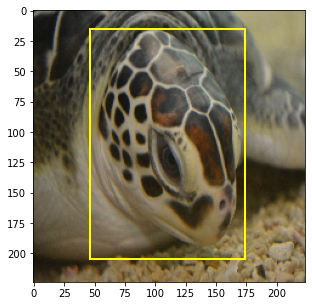

In [57]:
predict_yolo_path("../imgs/Outras/greenturtleface1.jpg")

Read in image of size 224 by 224 by 3
Predicted YOLO Bounding Box
[0.3980832  0.37370652 0.3348158  0.45014563]
Predicted Pixel Corners Bounding Box
[52, 33, 127, 134]


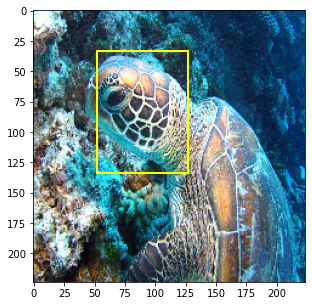

In [58]:
predict_yolo_path("../imgs/Outras/turtle2.jpg")